# Unweighted Max-Cut with QAOA and SPSA

## Setup

### Dependencies

In [1]:
import itertools
import random
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_algorithms.optimizers import SPSA
from qiskit.visualization import plot_distribution
import numpy as np
import rustworkx as rx
from rustworkx.visualization import mpl_draw
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import RemoveBarriers
from qiskit.providers.fake_provider import FakeCairoV2
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt

### Settings

In [2]:
# --- SETTINGS ---

# Before you edit these there are a few things to note.
#
# The number of edges and weights and their corresponding definitions need to agree.
# That is, if you change NUM_EDGES to 1 and EDGES has 5 edges then you'll have issues.
# Note that vertices are numbered 0, 1, ..., NUM_VERTICES.
# You can also select USE_RANDOM_EDGES_AND_WEIGHTS to ignore the specified edges and weights.
#
# The min and max weights are set to 1 to represent an unweighted graph (see Max-Cut explanation in paper).
# You can change these bounds to utilize other weighted graphs.
# That said, you will likely find that accuracy is greatly reduced.
# 
# You can test with randomly generated edges given the below bounds by setting
#     USE_RANDOM_EDGES_AND_WEIGHTS to True.
# Alternatively you can manually specify new edges and weights after changing the bounds.

NUM_VERTICES = 6
NUM_EDGES = 10
MIN_EDGE_WEIGHT = 1
MAX_EDGE_WEIGHT = 1

# Set to True to use noisy simulator
NOISY_SIMULATOR = True

P = 3
SHOTS = 20000
SPSA_ITERS = 300

# To specify edges and weights set USE_RANDOM_EDGES_AND_WEIGHTS to False
# Make sure to change NUM_VERTICES, NUM_EDGES, and *_EDGE_WEIGHT as well
USE_RANDOM_EDGES_AND_WEIGHTS = False
EDGES = [(0, 2), (0, 3), (0, 4), (1, 2), (1, 4), (1, 5), (2, 3), (3, 4), (3, 5), (4, 5)]
WEIGHTS = {}
for e in EDGES:
    WEIGHTS[e] = 1

In [3]:
NUM_QUBITS = NUM_VERTICES

In [4]:
# Setup backend
backend = None
if NOISY_SIMULATOR:
    backend = FakeCairoV2()
    backend.set_options(shots=SHOTS)
    backend = AerSimulator.from_backend(backend)
else:
    backend = AerSimulator()
    backend.set_options(shots=SHOTS)

## Input Graph

### Create Graph

In [5]:
# Create input graph
V = [i for i in range(0, NUM_VERTICES)]
E = EDGES
W = WEIGHTS
if USE_RANDOM_EDGES_AND_WEIGHTS:
    E = random.sample([(i, j) for (i, j) in itertools.combinations(V, 2)], NUM_EDGES)
    W = {}
    for (i, j) in E:
        W[(i, j)] = random.randrange(MIN_EDGE_WEIGHT, MAX_EDGE_WEIGHT + 1)

# Print input graph
print(f"V: {V}")
print(f"E: {E}")
print(f"W: {W}")

V: [0, 1, 2, 3, 4, 5]
E: [(0, 2), (0, 3), (0, 4), (1, 2), (1, 4), (1, 5), (2, 3), (3, 4), (3, 5), (4, 5)]
W: {(0, 2): 1, (0, 3): 1, (0, 4): 1, (1, 2): 1, (1, 4): 1, (1, 5): 1, (2, 3): 1, (3, 4): 1, (3, 5): 1, (4, 5): 1}


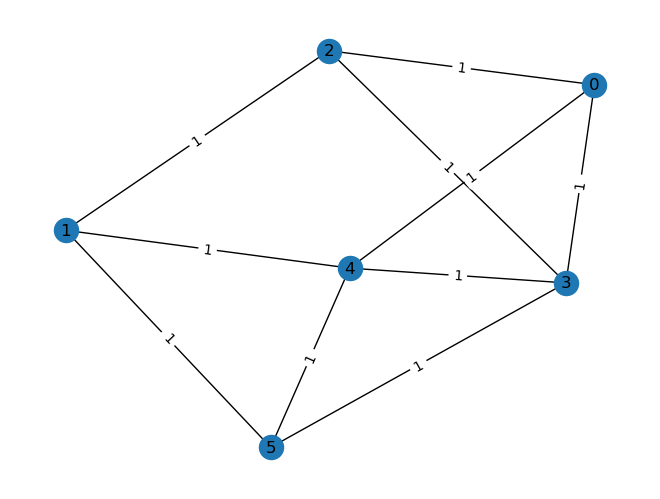

In [6]:
# Draw input graph
G_draw = rx.PyGraph()
G_draw.add_nodes_from(V)
G_draw.add_edges_from([(i, j, W[(i, j)]) for (i, j) in E])
mpl_draw(
    G_draw,
    with_labels=True,
    edge_labels=str
)

## Create Hamiltonians

### Cost Hamiltonian

In [7]:
# Create the cost hamiltonian as described in the paper
cost_hamiltonian = SparsePauliOp.from_sparse_list([("ZZ", [i, j], W[(i, j)]) for (i, j) in E], num_qubits=NUM_QUBITS)

# Print the cost hamiltonian
print(cost_hamiltonian.to_matrix())

[[10.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  4.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  4.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 ...
 [ 0.+0.j  0.+0.j  0.+0.j ...  4.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  4.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j 10.+0.j]]


### Mixer Hamiltonian

In [8]:
# Create the mixer hamiltonian as described in the paper
mixer_hamiltonian = SparsePauliOp.from_sparse_list([("X", [i], 1) for i in range(NUM_QUBITS)], num_qubits=NUM_QUBITS)

# Print the mixer hamiltonian
print(mixer_hamiltonian.to_matrix())

[[0.+0.j 1.+0.j 1.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 1.+0.j 1.+0.j 0.+0.j]]


## Create Ansatz

In [9]:
# Start in initial state |s> (superposition)
ansatz = QuantumCircuit(NUM_QUBITS)
for qubit in range(NUM_QUBITS):
    ansatz.h(qubit)

# Define parameters γ and β for each layer i
gamma = [Parameter(f'γ_{i}') for i in range(0, P)]
beta = [Parameter(f'β_{i}') for i in range(0, P)]

# Apply cost unitary U(C, γ_i) and mixer unitary U(B, β_i) P times in an alternating manner
for i in range(0, P):

    # Add barrier for visual separation
    ansatz.barrier()
    
    # Apply the cost unitary U(C, γ_i)
    cost_unitary = PauliEvolutionGate(cost_hamiltonian, gamma[i], f'U(C, γ_{i})')
    ansatz.append(cost_unitary, range(0, NUM_QUBITS))

    # Add barrier for visual separation
    ansatz.barrier()

    # Apply the mixer unitary U(B, β_i)
    mixer_unitary = PauliEvolutionGate(mixer_hamiltonian, beta[i], f'U(B, β_{i})')
    ansatz.append(mixer_unitary, range(0, NUM_QUBITS))

ansatz.measure_all()

C:\Users\Newt\AppData\Roaming\Python\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:164: UserWarning: Style JSON file 'iqp.json' not found in any of these locations: C:\Users\Newt\AppData\Roaming\Python\Python311\site-packages\qiskit\visualization\circuit\styles\iqp.json, iqp.json. Will use default style.
  self._style, def_font_ratio = load_style(style)


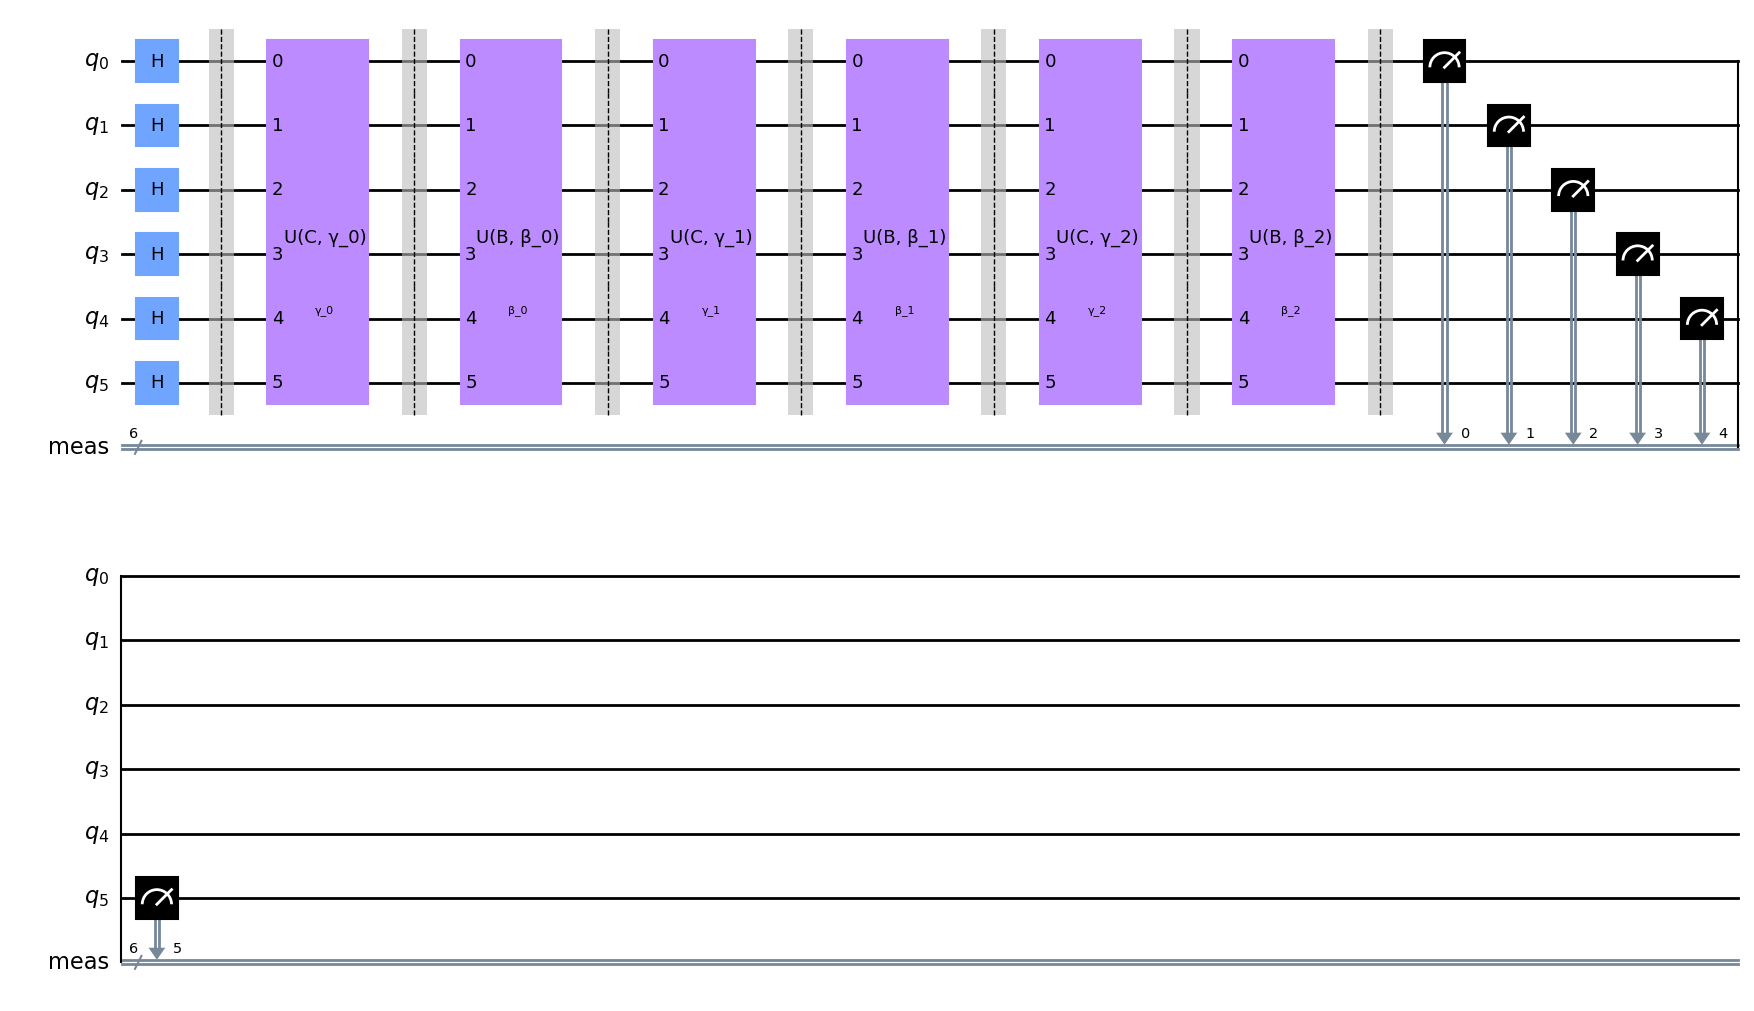

In [10]:
# Visualize the ansatz at a high-level
ansatz.draw(output="mpl", style="iqp")

C:\Users\Newt\AppData\Roaming\Python\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:164: UserWarning: Style JSON file 'iqp.json' not found in any of these locations: C:\Users\Newt\AppData\Roaming\Python\Python311\site-packages\qiskit\visualization\circuit\styles\iqp.json, iqp.json. Will use default style.
  self._style, def_font_ratio = load_style(style)


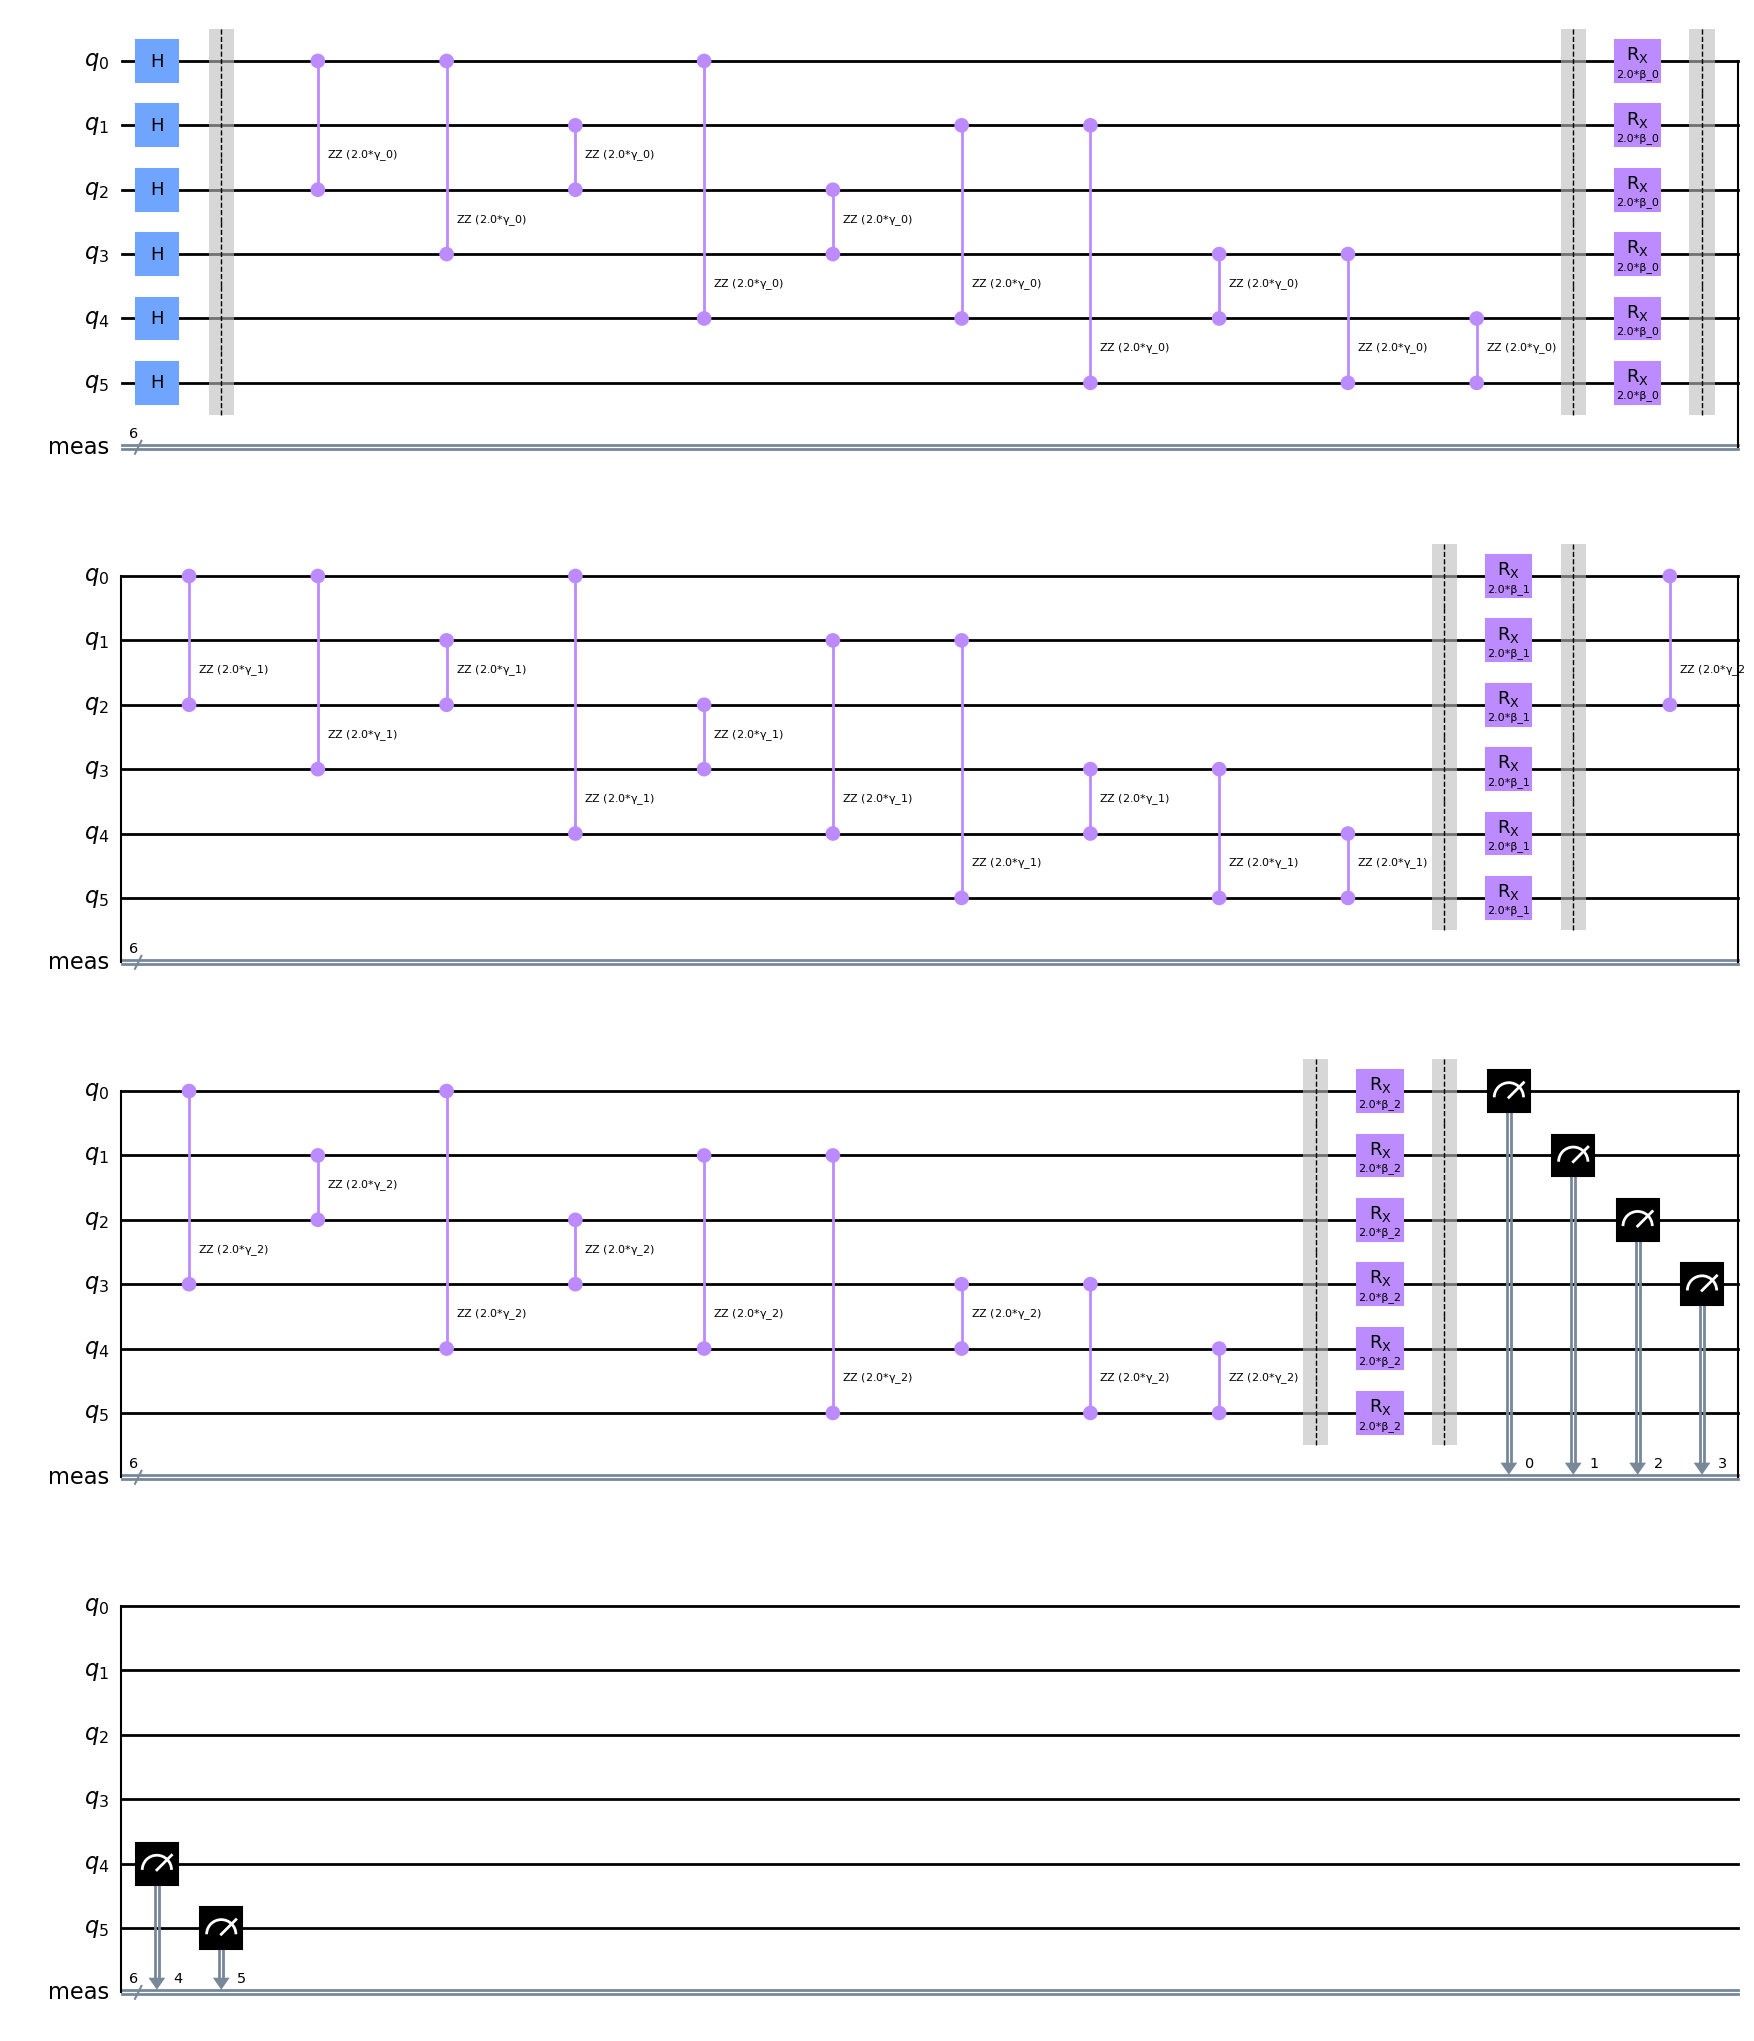

In [11]:
# Visualize ansatz at a lower level
transpile(ansatz, optimization_level=3).draw(output="mpl", style="iqp")

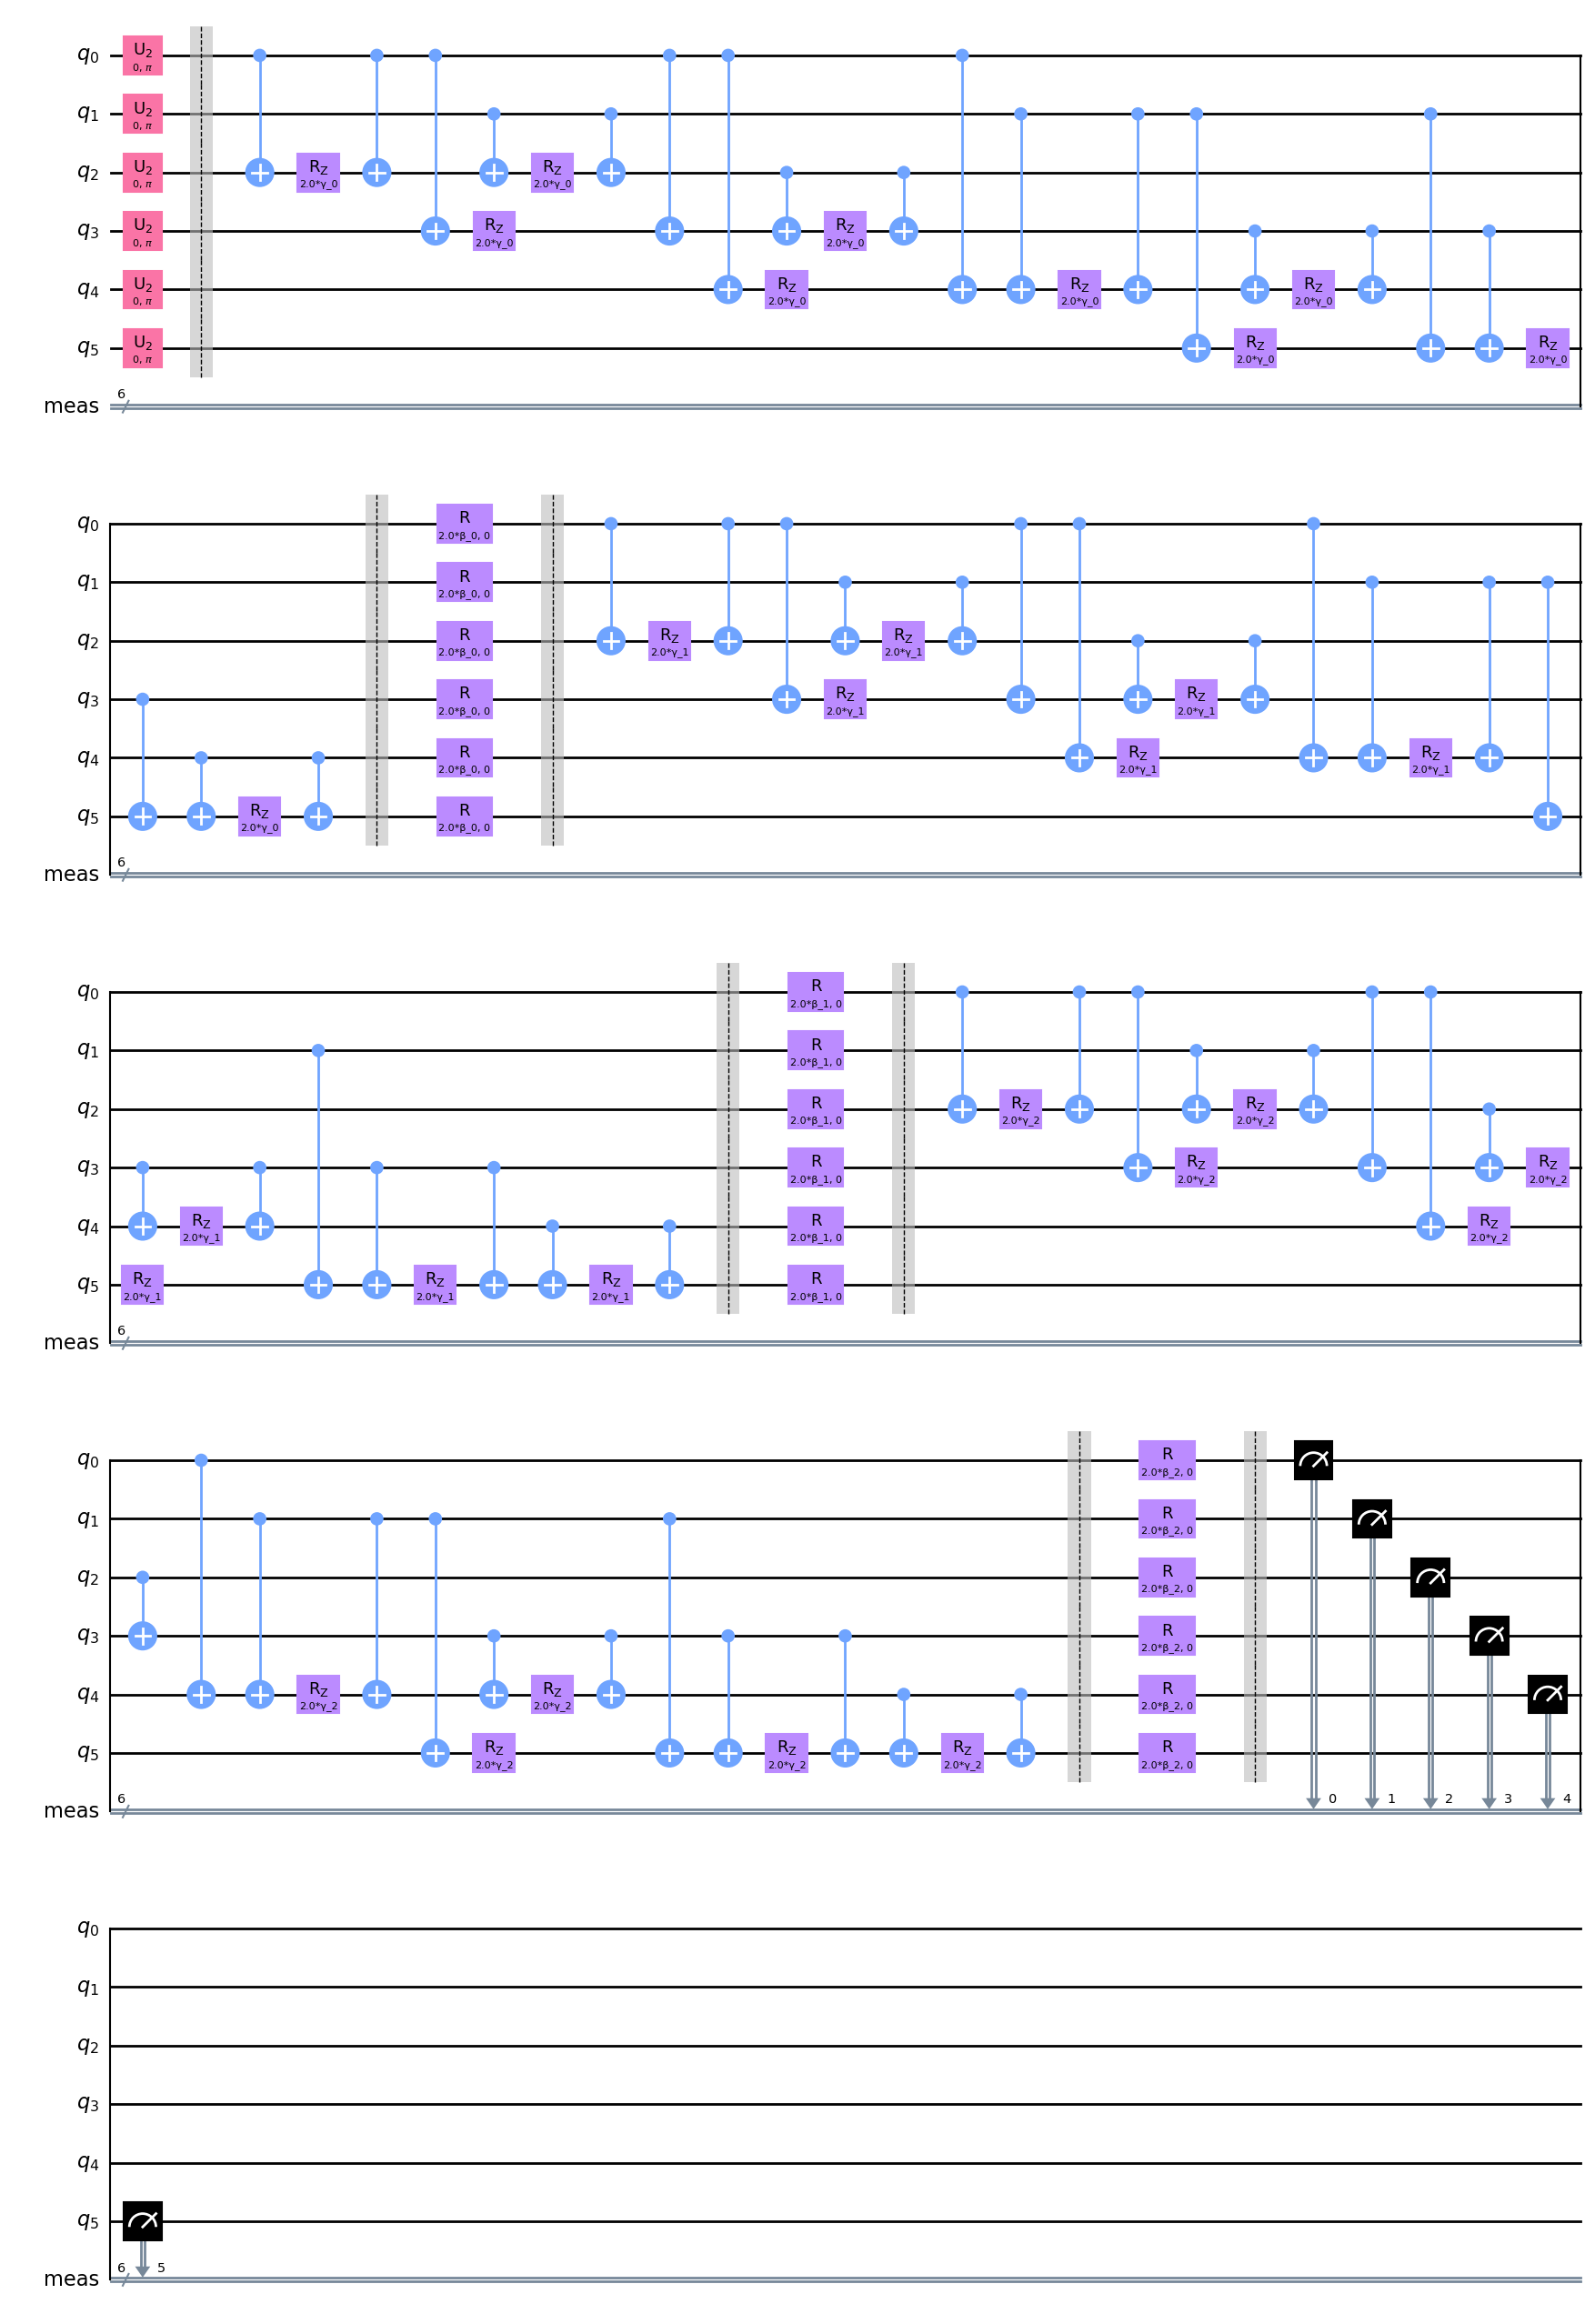

In [12]:
# Visualize ansatz at an even lower level
transpile(ansatz, optimization_level=3).decompose().draw(output="mpl", style="iqp")

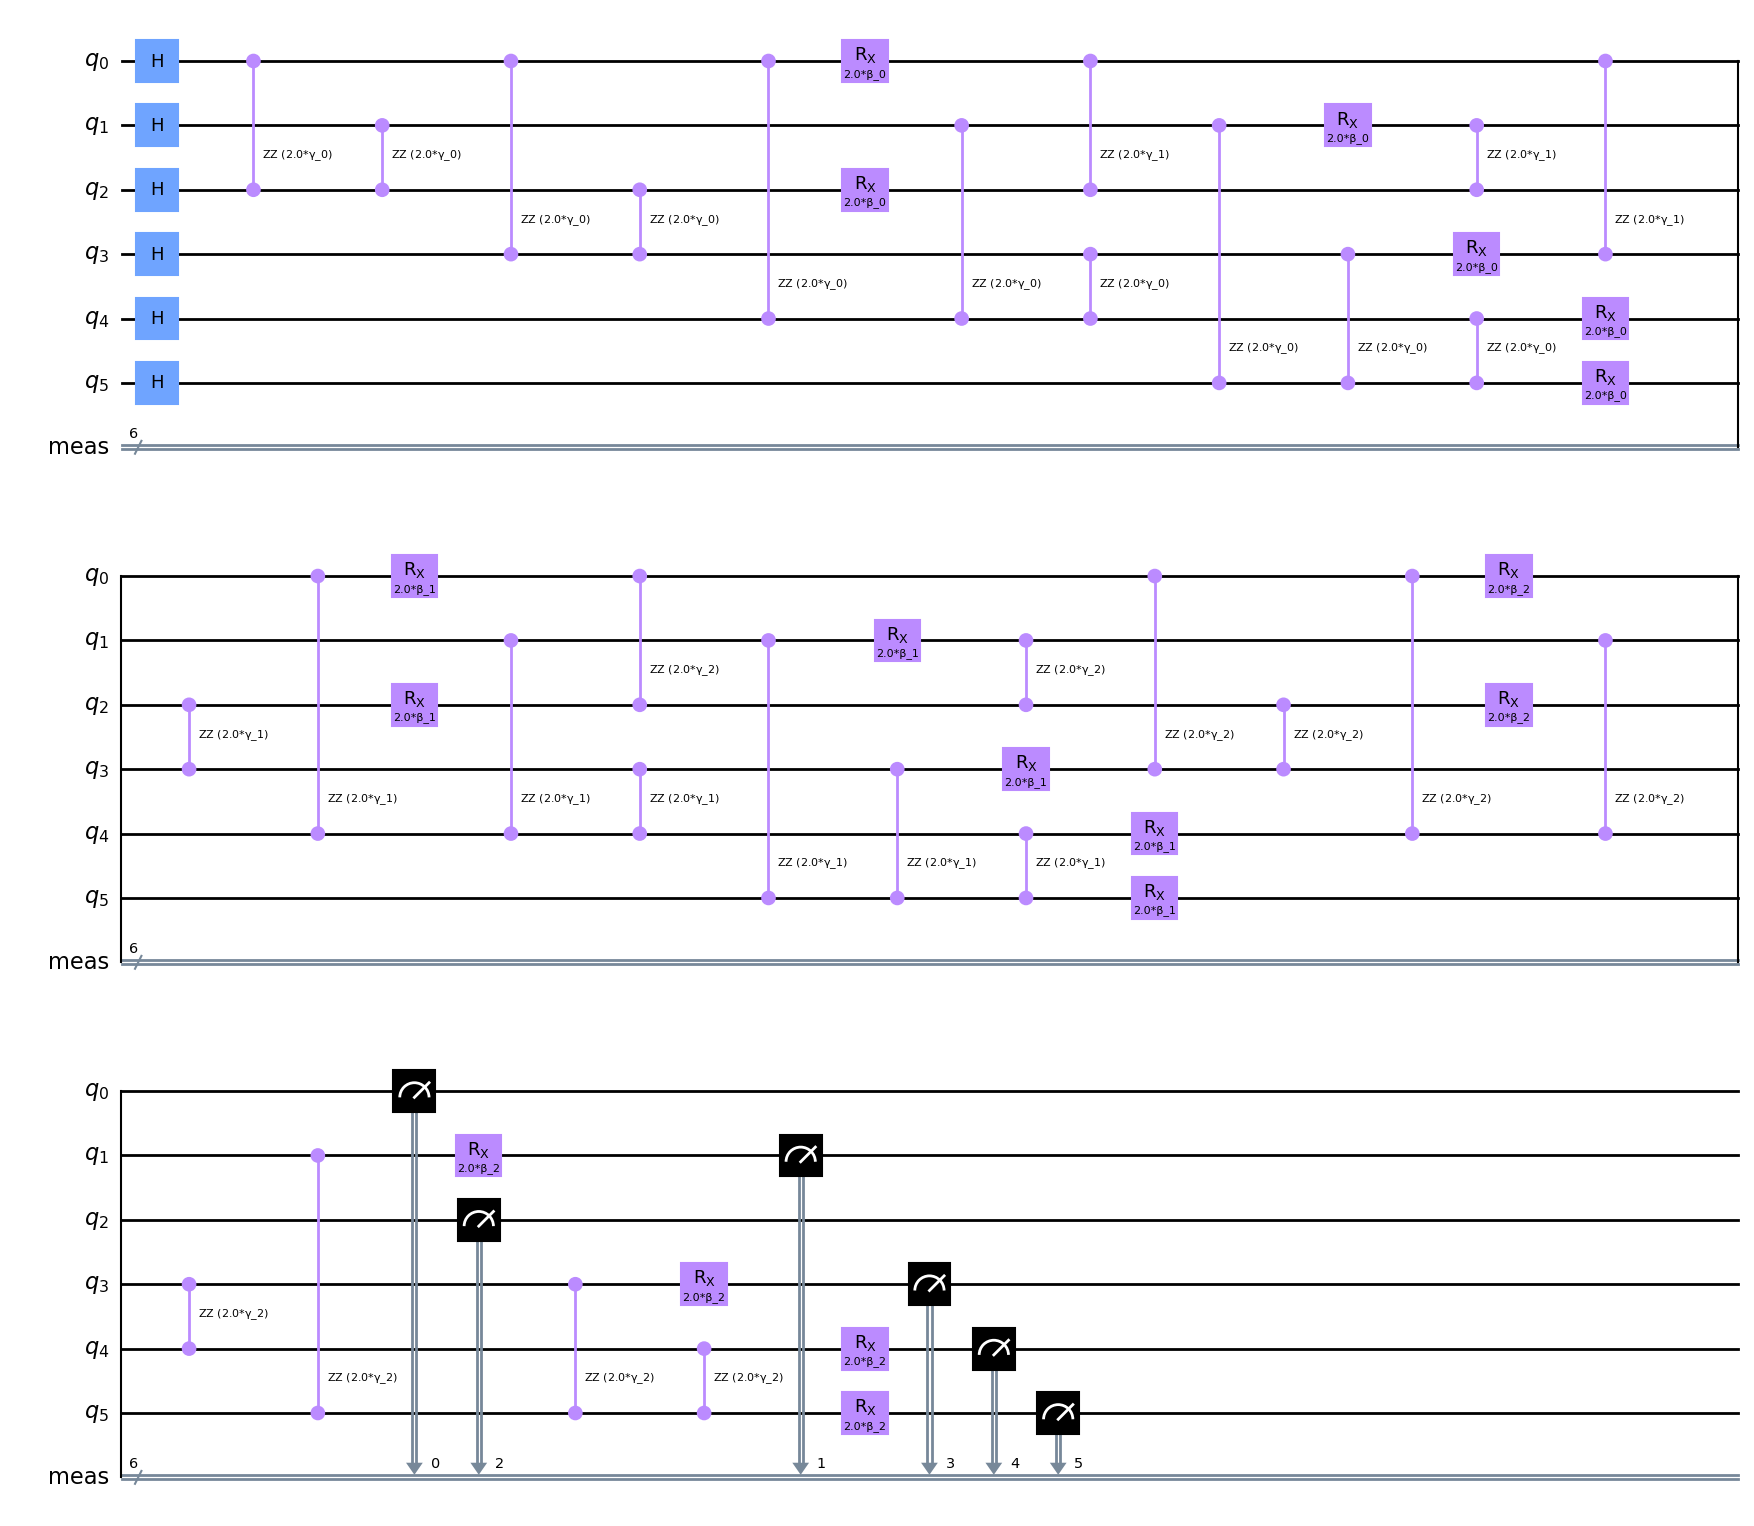

In [13]:
# Optimize the circuit's construction
pass_manager = PassManager()
pass_manager.append(RemoveBarriers())
ansatz = pass_manager.run(ansatz)
ansatz = transpile(ansatz, optimization_level=3)
ansatz.draw(output="mpl", style="iqp")

## Iterative Optimization

In [14]:
# Define our cost function
def cost_func(params, ansatz=ansatz, hamiltonian=cost_hamiltonian):
    bound_ansatz = ansatz.assign_parameters(params)
    job = backend.run(bound_ansatz)
    result = job.result()
    counts = result.get_counts(bound_ansatz)
    counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True)[:int(2 ** NUM_QUBITS / 2)])
    cost = 0
    all_v = 0
    for (k, v) in counts.items():
        for i, j in E:
            if k[i] == k[j]:
                cost += v
            else:
                cost -= v
            all_v += v
    return cost / all_v

# Randomly initialize our set of initial parameters
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

# Collect calculated costs for convergence plot later
convergence_data = []
def cbfunc(evals, pars, fx, ss, sa):
    # print(evals / 3, fx)
    convergence_data.append(fx)

# Perform optimization with SPSA
spsa = SPSA(maxiter=SPSA_ITERS, callback=cbfunc)
res = spsa.minimize(cost_func, x0)

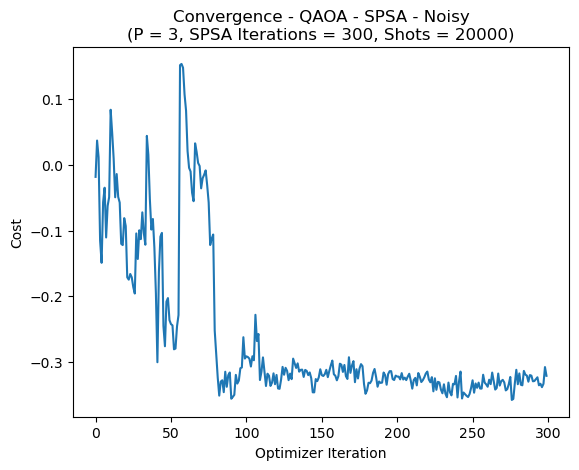

In [15]:
# Plot convergence data
plt.plot(convergence_data)
plt.xlabel('Optimizer Iteration')
plt.ylabel('Cost')
plt.title(f"Convergence - QAOA - SPSA - {'Noisy' if NOISY_SIMULATOR else 'Ideal'}\n(P = {P}, SPSA Iterations = {SPSA_ITERS}, Shots = {SHOTS})")
plt.savefig(f"convergence-qaoa-spsa-{'noisy' if NOISY_SIMULATOR else 'ideal'}-p_{P}-its_{SPSA_ITERS}.pgf")
plt.show()

## Results

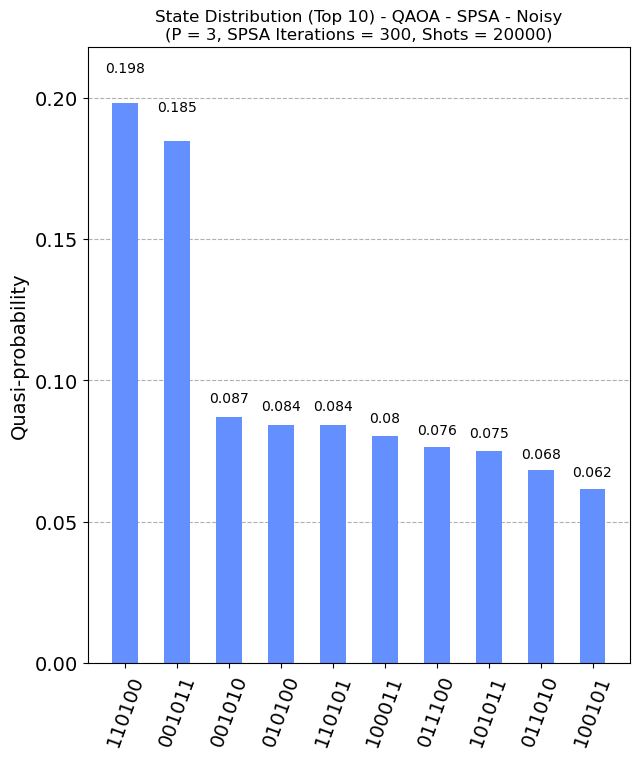

In [16]:
# Do final run with optimized parameters
bound_ansatz = ansatz.assign_parameters(res.x)
job = backend.run(bound_ansatz)
result = job.result()
counts = result.get_counts(bound_ansatz)

# Plot the results
plot_distribution(counts, figsize=(7, 8), number_to_keep=10, sort='value_desc', title=f"State Distribution (Top 10) - QAOA - SPSA - {'Noisy' if NOISY_SIMULATOR else 'Ideal'}\n(P = {P}, SPSA Iterations = {SPSA_ITERS}, Shots = {SHOTS})", filename=f"distribution-qaoa-spsa-{'noisy' if NOISY_SIMULATOR else 'ideal'}-p_{P}-its_{SPSA_ITERS}.pgf")
plot_distribution(counts, figsize=(7, 8), number_to_keep=10, sort='value_desc', title=f"State Distribution (Top 10) - QAOA - SPSA - {'Noisy' if NOISY_SIMULATOR else 'Ideal'}\n(P = {P}, SPSA Iterations = {SPSA_ITERS}, Shots = {SHOTS})")

PARTITIONS:
	V1: {0, 1, 3}
	V2: {2, 4, 5}


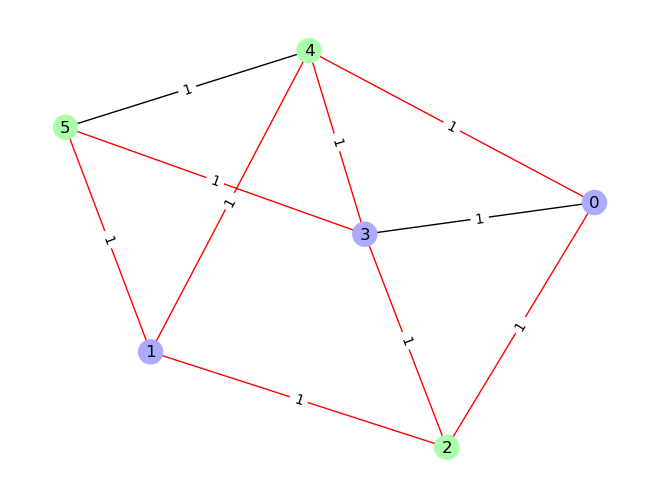

In [17]:
# Helper function that sums equivalent states
def calc_count(bitstring):
    count = counts.get(bitstring)
    count_flipped = counts.get(''.join(['1' if i == '0' else '0' for i in bitstring]))
    if count_flipped is None:
        count_flipped = 0
    return count + count_flipped

# Create partitions
Y = [int(i) if int(i) == 1 else -1 for i in max(counts, key=calc_count)[::-1]]
V_1 = set([v for v in V if Y[v] == -1])
V_2 = set([v for v in V if Y[v] == 1])

# Print vertex subsets
print("PARTITIONS:")
print(f"\tV1: {V_1}")
print(f"\tV2: {V_2}")

# Visualize result graph
mpl_draw(
    G_draw,
    with_labels=True,
    edge_labels=str,
    node_color=["#aaffaa" if kk == 1 else "#aaaaff" for kk in Y],
    edge_color=["#ff0000" if (i in V_1 and j in V_2) or (i in V_2 and j in V_1) else "#000000" for (i, j) in E] 
)

### Correctness Check

In [18]:
# Brute force the expected solution on a classical machine
def brute_force(E=E, W=W):
    max_w = -1
    max_Y = None
    itertools.product([[-1, 1] for _ in range(NUM_VERTICES)])
    for Y in itertools.product(*[[-1, 1] for _ in range(NUM_VERTICES)]):
        w = 0
        for (i, j) in E:
            if Y[i] != Y[j]:
                w += W[(i, j)]
        if w > max_w:
            max_w = w
            max_Y = Y
    return sum([W[i, j] for (i, j) in E if max_Y[i] != max_Y[j]])

expected = brute_force()

# Get the solution we actually computed
actual = sum([W[i, j] for (i, j) in E if Y[i] != Y[j]])

# Verify that the results match up
print("CORRECT" if expected == actual else "INCORRECT")
print(f"\tEXPECTED : {expected}")
print(f"\tACTUAL   : {actual}")

CORRECT
	EXPECTED : 8
	ACTUAL   : 8


## References

We referenced the following sources for our implementation.

* [https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm)
* [https://docs.quantum.ibm.com/](https://docs.quantum.ibm.com/)
* [https://learning.quantum.ibm.com/course/variational-algorithm-design](https://learning.quantum.ibm.com/course/variational-algorithm-design)

We additionally utilized ChatGPT as a resource for learning and clarification during our implementation.